In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pprint
import pickle
import json
import os, sys
os.chdir("../")
sys.path.append('src/')
from util import *

# Monolithic and RA results

In [2]:
def fill_df(df, m):
    added = []
    for n in range(1, m+1):
        for k in range(1, m+1):
            if len(df.loc[(df["n"] == n) & (df["k"] == k)]) == 0:
                added.append({"n": n, "k": k, "expanded transitions": float("inf"), "synthesis time(ms)": float("inf")})
    df = pd.concat([df, pd.DataFrame(added)], ignore_index=True)
    return df

monolithic_results = {}
for problem in ["AT", "TA", "TL", "DP", "BW", "CM"]:
    df = pd.read_csv("experiments/results/ResultsPaper/"+problem+".csv")
    df = df.loc[df["controllerType"] == "mono"]
    df["n"] = df["testcase"].apply(lambda t: int(t.split("-")[1]))
    df["k"] = df["testcase"].apply(lambda t: int(t.split("-")[2]))
    df = fill_df(df, 15)
    monolithic_results["expanded transitions", problem] = df.pivot("n", "k", "expandedTransitions")
    monolithic_results["synthesis time(ms)", problem] = df.pivot("n", "k", "synthesisTimeMs")


ra_results = {}
for problem in ["AT", "TA", "TL", "DP", "BW", "CM"]:
    df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/all_ra_afterfix_15.csv")
    df = fill_df(df, 15)
    ra_results["expanded transitions", problem] = df.pivot("n", "k", "expanded transitions")
    ra_results["synthesis time(ms)", problem] = df.pivot("n", "k", "synthesis time(ms)")
    

ra_sola_results = {}
for problem in ["AT", "TA", "TL", "DP", "BW", "CM"]:
    df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/all_ra_sola_15.csv")
    df = fill_df(df, 15)
    ra_sola_results["expanded transitions", problem] = df.pivot("n", "k", "expanded transitions")
    ra_sola_results["synthesis time(ms)", problem] = df.pivot("n", "k", "synthesis time(ms)")
    
random_results_small = {}
for problem in ["AT", "TA", "TL", "DP", "BW", "CM"]:
    for n, k in [(2, 2), (3, 3)]:
        df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/random.csv")
        random_results_small[(problem, n, k)] = list(df["expanded transitions"])
        
random_results = {}
for problem in ["AT", "TA", "TL", "DP", "BW", "CM"]:
    df = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/all_random.csv")
    df = fill_df(df, 15)
    random_results["expanded transitions", problem] = df.pivot("n", "k", "expanded transitions")
    random_results["synthesis time(ms)", problem] = df.pivot("n", "k", "synthesis time(ms)")

In [ ]:
def plot_ra_expanded_transitions(problem, n, k, norm=False, label="RA", color="r"):
    ra = ra_results["expanded transitions", problem][n][k]
    mono = monolithic_results["expanded transitions", problem][n][k]
    if norm:
        print("RA", ra/mono)
        plt.text(5, ra/mono, "RA")
        plt.axhline(y=ra/mono, color=color, linestyle='-', label=label)
    else:
        print("RA", ra)
        plt.text(5, ra, "RA")
        plt.axhline(y=ra, color=color, linestyle='-', label=label)

def plot_random_expanded_transitions(problem, n, k, norm=False, label="Random", color="g", use_min=False):
    if use_min:
        random = min(random_results_small[(problem, n, k)])
    else:
        random = np.mean(random_results_small[(problem, n, k)])
    mono = monolithic_results["expanded transitions", problem][n][k]
    # print(ra, mono, ra/mono)
    if norm:
        plt.text(5, random/mono, label)
        plt.axhline(y=random/mono, color=color, linestyle='-', label=label)
    else:
        plt.text(5, random, label)
        plt.axhline(y=random, color=color, linestyle='-', label=label)
    
    
def df_preprocess(df, base, window_size=4):
    df["best transitions"] = df["expanded transitions"].cummin()
    
    df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
    df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["n"]][r["k"]], axis=1)
    df["expanded transitions / total"] = df["expanded transitions"] / df["total transitions"]
    df["mean transitions / total"] = df["mean transitions"] / df["total transitions"]
    
    df["instance"] = df.apply((lambda r: (r["problem"], r["n"], r["k"])), axis=1)

# Comparing transitions

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#problems = ["AT", "BW", "CM", "DP"]

files = ["5mill_C"]

for problem in problems:
    dfs = []
    n2, k2 = 5, 5
    for n, k, file  in [(2, 2, f) for f in files]:
        df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
        df = df.loc[(df["n"]==n2)&(df["k"]==k2)]
        df["best transitions"] = df["expanded transitions"].cummin()
        #df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        #df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["n"]][r["k"]], axis=1)
        #df["expanded transitions / total"] = df["expanded transitions"] / df["total transitions"]
        #df["mean transitions / total"] = df["mean transitions"] / df["total transitions"]
    
        df["case"] = filename([n, k, file])
        #print(list(df["expanded transitions"]))
        dfs.append(df)
        print(problem, file, dfs[-1]["expanded transitions"].dropna().min())
        print(list(dfs[-1].loc[dfs[-1]["expanded transitions"] == dfs[-1]["expanded transitions"].min()]["idx"]))
        df["expanded transitions"] = df["expanded transitions"].fillna(df["expanded transitions"].max()+10)
        
    df = pd.concat(dfs, ignore_index=True)
    sns.lineplot(data = df, x="idx", y="expanded transitions", hue="case")

    #plot_ra_expanded_transitions(problem, n2, k2, norm=False)
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, label="Random mean")
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, use_min=True, label="Random min")
    plt.title(" ".join([problem, str(n2), str(k2)]))
    #plt.tight_layout()
    plt.legend(prop={'size': 7})
    #plt.savefig("experiments/figures/context/best/"+filename([problem, n2, k2])+".jpg", dpi=500)
    plt.show()

## Plot solved

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#problems = ["AT", "BW", "CM", "DP"]

files = ["5mill_C"]

for problem in problems:
    dfs = []
    df_solved = []
    for file in files:
        df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/generalization_all.csv")
        solved = [0 for i in range(101)]
        for x, cant in dict(df["idx"].value_counts()).items():
            df_solved.append({"idx": x, "solved": cant, "file": file})
        dfs.append(df)
    df_solved = pd.DataFrame(df_solved)
    df = pd.concat(dfs, ignore_index=True)
    idx_best = df_solved.loc[df_solved["solved"] == df_solved["solved"].max()]["idx"].iloc[0]
    print(idx_best)
    if problem != "CM":
        print(df.loc[(df["idx"] == idx_best)&(df["n"]==3)&(df["k"]==3)]["expanded transitions"].iloc[0])
        print(df.loc[(df["n"]==3)&(df["k"]==3)]["expanded transitions"].min())
    
    sns.lineplot(data=df_solved, x="idx", y="solved", hue="file")
    plt.title(problem)
    plt.tight_layout()
    
    plt.show()
    #plot_ra_expanded_transitions(problem, n2, k2, norm=False)
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, label="Random mean")
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, use_min=True, label="Random min")
    #plt.legend(prop={'size': 7})
    #plt.savefig("experiments/figures/context/best/"+filename([problem, n2, k2])+".jpg", dpi=500)
   # plt.show()
    



In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
problems = ["AT", "BW", "CM", "DP"]
#files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
#files = ["TB_5mill", "ra_feature2opt_2h", "base_features_2h"]
#files = ["ra_feature2opt_2h"]
#files = ["base_features_2h", "ra_feature2opt_2h", "TB_5mill", "labels_2h"]
#files = ["TB_5mill_2000", "TB_5mill_5000", "TB_5mill", "ra_feature2opt_2h"]
files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "TB_5mill", "labels_2h"]
files = ["5mill_C", "5mill_L", "5mill_RA", "ra_feature2opt_2h"]
files = ["5mill_C"]

#files = ["5mill_C"]
for problem in problems:
    dfs = []
    n2, k2 = 2, 2
    for n, k, file  in [(2, 2, f) for f in files]:
        dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem, n2, k2])+".csv"))
        df_preprocess(dfs[-1], 200000, 8)
        #if file == "5mill_C":
        #    dfs[-1] = dfs[-1].loc[dfs[-1]["idx"] % 5 == 0]
        dfs[-1]["case"] = filename([n, k, file])
        print(problem, file, dfs[-1]["expanded transitions"].dropna().min())
        print(list(dfs[-1].loc[dfs[-1]["expanded transitions"] == dfs[-1]["expanded transitions"].min()]["idx"]))
    
    df = pd.concat(dfs, ignore_index=True)
    sns.lineplot(data = df, x="training steps", y="expanded transitions", hue="case")

    #plot_ra_expanded_transitions(problem, n2, k2, norm=False)
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, label="Random mean")
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, use_min=True, label="Random min")
    plt.title(" ".join([problem, str(n2), str(k2)]))
    #plt.tight_layout()
    plt.legend(prop={'size': 7})
    #plt.savefig("experiments/figures/context/best/"+filename([problem, n2, k2])+".jpg", dpi=500)
    plt.show()

## Comparing transitions from different n and k

In [ ]:
problems = ["AT"]

#files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
#files = ["TB_5mill", "ra_feature2opt_2h", "base_features_2h"]
#files = ["ra_feature2opt_2h"]
#files = ["base_features_2h", "ra_feature2opt_2h", "TB_5mill", "labels_2h"]
#files = ["TB_5mill_2000", "TB_5mill_5000", "TB_5mill", "ra_feature2opt_2h"]
files = ["labels_2h", "TB_5mill", "ra_feature2opt_2h"]
#files = ["TB_5mill", "labels_2h"]
files = ["5mill", "1mill_eta1e-4"]

for problem in problems:
    dfs = []
    n, k, file = (3, 3, "5mill")
    for n2 in range(1, 5):
        for k2 in range(1, 5):
            dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem, n2, k2])+".csv"))
            df_preprocess(dfs[-1], 200000, 20)
            dfs[-1]["case"] = filename([n, k, file, n2, k2])

            print(problem, file, n2, k2, dfs[-1]["expanded transitions"].dropna().min())
            #print(list(dfs[-1].loc[dfs[-1]["expanded transitions"] == dfs[-1]["expanded transitions"].min()]["idx"]))
    
    df = pd.concat(dfs, ignore_index=True)

    sns.lineplot(data = df, x="training steps", y="mean transitions / total", hue="case")

    #plot_ra_expanded_transitions(problem, n2, k2, norm=False)
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, label="Random mean")
    #plot_random_expanded_transitions(problem, n2, k2, norm=False, use_min=True, label="Random min")
    plt.title(" ".join([problem, str(n), str(k)]))
    plt.tight_layout()
    #plt.savefig("experiments/figures/TB/batch size/"+filename([problem2, n2, k2])+"_bs_3_3.jpg", dpi=200)
    plt.show()

## Transitions table

In [ ]:
files = ["base_features_2h", "ra_feature2opt_2h", "TB_5mill", "labels_2h"]
#files = ["base_features_2h", "ra_feature2opt_2h"]
#files = ["ra_feature2opt_2h", "TB_5mill"]
#files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]
files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "TB_5mill", "labels_2h"]
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
for problem in problems:
    x = PrettyTable()
    x.field_names = [problem, "min 2", "min 3", "min mean 2", "idx mm2", "min mean 3", "idx mm3", "last q", "ra 2", "ra 3"]
    for file in files:
        df_2_2 = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, 2, 2])+".csv")
        df_3_3 = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/"+filename([problem, 3, 3])+".csv")
        df_q = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/q.csv")

        min_2_2 = df_2_2["expanded transitions"].min()
        min_3_3 = df_3_3["expanded transitions"].min()

        window_size = 5
        df_2_2["mean transitions"] = list(np.convolve(list(df_2_2["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        df_3_3["mean transitions"] = list(np.convolve(list(df_3_3["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        min_mean_2_2 = df_2_2["mean transitions"].min()
        min_mean_3_3 = df_3_3["mean transitions"].min()
        min_mean_idx_2_2 = df_2_2["mean transitions"].argmin()
        min_mean_idx_3_3 = df_3_3["mean transitions"].argmin()
        
        ra_2_2 = ra_results["expanded transitions", problem][2][2]
        ra_3_3 = ra_results["expanded transitions", problem][3][3]
        last_q = -df_q.iloc[-1]["avg q"]
        x.add_row([file, min_2_2, min_3_3, min_mean_2_2, min_mean_idx_2_2 / 100, min_mean_3_3, min_mean_idx_3_3 / 20, last_q, ra_2_2, ra_3_3])
    print(x)

# Comparing avg Q

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
problems = ["TA"]

files = ["T_1mill", "TB_1mill"]
files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
files = ["ra_feature2opt_2h", "ra_feature2_target"]
files = ["TB_5mill", "ra_feature2opt_2h"]
files = ["TB_5mill", "TB_5mill_2000", "TB_5mill_5000"]
files = ["TB_5mill", "TB_5mill_b100000"]
files = ["TB_5mill", "base_features_2h"]
files = ["base_features_2h", "TB_5mill", "labels_2h"]
files = ["base_features_2h", "ra_feature2opt_2h", "TB_5mill", "labels_2h"]
files = ["TB_5mill_2000", "TB_5mill_5000", "TB_5mill", "ra_feature2opt_2h"]
files = ["TB_5mill", "TB_5mill_bs100", "ra_feature2opt_2h", "base_features_2h"]
files = ["labels_2h", "ra_feature2opt_2h"]
files = ["5mill"]
files = ["normalized", "1mill_eta1e-4"]
files = ["50mill"]

files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]
files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "TB_5mill", "labels_2h"]
files = ["5mill_RA", "ra_feature2opt_2h"]

for problem, n, k in [(x, 2, 2) for x in problems]:
    dfs = []
    for file in files:
        if file != "ra_feature2opt_2h" or problem != "CM":
            dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/q.csv"))
            dfs[-1]["file"] = file
    df = pd.concat(dfs, ignore_index=True)
    df["avg q"] = -df["avg q"]
    sns.lineplot(data = df, x="training steps", y="avg q", hue="file")
    
    plt.title(" ".join([problem, str(n), str(k), "q"]))
    plt.savefig("experiments/figures/q.jpg", dpi=200)
    plt.show()

In [ ]:
for problem in problems:
    print(problem, monolithic_results[(problem, 2, 2)], monolithic_results[(problem, 3, 3)], end=" ")
    print(monolithic_results[(problem, 4, 4)] if problem != "CM" else "nan")

## Time of evaluating up to 4 4

In [ ]:
for problem in ["AT", "BW", "CM", "DP", "TA", "TL"]:
    df_agent = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/TB_5mill/all.csv")
    df_agent = fill_df(df_agent, 15)
    agent_t = df_agent.pivot("n", "k", "synthesis time(ms)")
    print(problem)
    print(agent_t / 1000)
    agent_t = agent_t.fillna(float("inf"))
    print(problem, np.sum([(agent_t[n][k] if n != 4 or k != k else 0) for n in range(1, 4) for k in range(1, 4)]) / (1000*60) * 200)

# Plotting Q

In [ ]:
problems = ["AT", "TA", "TL", "DP", "BW", "CM"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    df = pd.read_csv("experiments/results 25 mar/"+filename([problem, n, k])+"/10m_0.csv")
    df["avg q"] = -df["avg q"]
    sns.lineplot(data=df, x="training time", y="avg q")
    
    plt.title(" ".join([problem, str(n), str(k), "q"]))
    
    plt.savefig("experiments/figures/10m_0/q/"+filename([problem, n, k])+".jpg", dpi=200)
    plt.show()

# Correlation 2 2 vs 3 3

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]

#files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
#files = ["TB_5mill", "ra_feature2opt_2h", "base_features_2h"]
#files = ["ra_feature2opt_2h"]
file = "TB_5mill"

for problem, n, k in [(x, 2, 2) for x in problems]:
    
    df1 = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem, 2, 2])+".csv")
    df2 = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem, 3, 3])+".csv")
    print(len(df1), len(df2))
    df = pd.DataFrame({"transitions 2 2": df1["expanded transitions"], "transitions 3 3": df2["expanded transitions"]})
    
    sns.regplot(data = df, x="transitions 2 2", y="transitions 3 3")
    plt.title(problem+" correlation")
    #plt.savefig("experiments/figures/2h/trans/"+filename([problem2, n2, k2, "no_round"])+".jpg", dpi=200)
    plt.show()

# Analyzing models output

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.regression.linear_model import OLS

a = 0
def plot_q_and_pred(m, df_features, features, problem):
    print(problem, m.rank_, m.intercept_)
    print(m.coef_)
    print(m.score(df_features[features], df_features["q"]))
    print(df_features["q"].min(), df_features["q"].max())
    df_features["pred"] = m.predict(df_features[features])
    df_features["pred"].plot(kind="hist")
    plt.title(("pred", problem))
    plt.show()
    plt.title("q")
    df_features["q"].plot(kind="hist")
    plt.title(("q", problem))
    plt.show()

def plot_features(problem, n, k, dir, last=False, ra_feature=True):
    problem2, n2, k2 = problem, 3, 3
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
    idx = best_agent_idx(df) if not last else last_agent_idx(df)
    t = "last" if last else "best"
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")
    
    features = feature_names({"ra feature": True}, problem)
    
    print(problem)
    
    #m = LinearRegression()
    #m.fit(df_features[features], df_features["q"])
    #plot_q_and_pred(m, df_features, features, problem)
    
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(df_features[features])
    constant_columns = [column for column in df_features[features].columns if column not in df_features[features].columns[constant_filter.get_support()]]
    print("Constant columns: ", constant_columns)
    X = df_features[features].loc[:, constant_filter.get_support()]
    #fvalues, pvalues = f_regression(X, df_features["q"])
    #print(fvalues.shape, pvalues.shape)
    df_features["q"] = (df_features["q"] - df_features["q"].mean()) / df_features["q"].std()
    m = OLS(df_features["q"], X)
    r = m.fit()
    print(r.params)
    plt.xticks(ha='right', rotation=55, fontsize=8)
    sns.barplot(x=X.columns, y=r.params)
    plt.title((problem, n, k))
    plt.savefig("experiments/figures/labels_2h/"+t+"_features/"+filename([problem, n, k, t, ra_feature])+".jpg", dpi=200, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, "labels_2h", last=False, ra_feature=True)
    #plot_features(problem, n, k, "TB_5mill", last=True, ra_feature=True)

In [ ]:
problem, n, k = "CM", 2, 2
last = False
ra_feature = True
dir = "ra_feature_2h"

problem2, n2, k2 = (problem, 3, 3) if problem != "CM" else (problem, 2, 2)
df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
idx = best_agent_idx(df) if not last else last_agent_idx(df)
t = "last" if last else "best"
df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")

m = LinearRegression()
m.fit(df_features[feature_names(ra_feature)], df_features["q"])
features = feature_names(ra_feature)
print(problem, m.rank_, m.intercept_)
print(m.coef_)
print(m.score(df_features[feature_names(ra_feature)], df_features["q"]))
df_features["pred"] = m.predict(df_features[feature_names(ra_feature)])

In [ ]:
[]
print(np.dot(m.coef_, [ for i in range(14)])+m.intercept_)

# Q Distribution

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_features(problem, n, k, dir, last=False, ra_feature=True):
    problem2, n2, k2 = (problem, 3, 3) if problem != "CM" else (problem, 2, 2)
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+filename([problem2, n2, k2])+".csv")
    idx = best_agent_idx(df) if not last else last_agent_idx(df)
    t = "last" if last else "best"
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/"+t+"_"+str(idx)+".csv")
    
    df_features["q"].plot(kind='hist');
    plt.title((problem, n, k))
    #plt.savefig("experiments/figures/2h/"+t+"_features/"+filename([problem, n, k, t, ra_feature])+".jpg", dpi=200, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "TA", "TL", "DP", "BW", "CM"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, "ra_feature_2h", last=False, ra_feature=True)
    #plot_features(problem, n, k, "ra_feature_2h", last=False, ra_feature=False)
    #plot_features(problem, n, k, "ra_feature_2h", last=True, ra_feature=True)
    #plot_features(problem, n, k, "ra_feature_2h", last=True, ra_feature=False)

## Training time proportional to size

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
problems = ["AT", "DP"]
#files = ["1mill", "T_1mill", "B_1mill", "TB_1mill"]
#files = ["TB_5mill", "ra_feature2opt_2h", "base_features_2h"]
#files = ["ra_feature2opt_2h"]
files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L", "5mill_C"]
#files = ["TB_5mill", "labels_2h"]

for problem, n, k in [(x, 2, 2) for x in problems]:
    problem2, n2, k2 = problem, 2, 2
    
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem2, n2, k2])+".csv"))
        if problem == "TA" and n2 == 3:
            dfs[-1] = dfs[-1].loc[dfs[-1]["idx"] % 5 == 0]
        df_preprocess(dfs[-1], 1, 8)
        size = monolithic_results[(problem2, n2, k2)]
        dfs[-1] = dfs[-1].loc[dfs[-1]["training steps"] < size * 10000]
        dfs[-1]["file"] = file
        # print(problem, file, dfs[-1]["synthesis time(ms)"].dropna().min(), "(ms)")
        print(problem, file, dfs[-1]["expanded transitions"].dropna().min(), "(trans)")
        print(list(dfs[-1].loc[dfs[-1]["expanded transitions"] == dfs[-1]["expanded transitions"].min()]["idx"]))
        if problem == "CM" and n2 == 3:
            print(dfs[-1].dropna(subset=["expanded transitions"])[["idx", "expanded transitions"]])
    df = pd.concat(dfs, ignore_index=True)
    
    sns.lineplot(data = df, x="rounded training steps", y="mean transitions", hue="file")
    
    plot_ra_expanded_transitions(problem2, n2, k2, norm=False)
    plot_random_expanded_transitions(problem2, n2, k2, norm=False, label="Random mean")
    plot_random_expanded_transitions(problem2, n2, k2, norm=False, use_min=True, label="Random min")
    plt.title(" ".join([problem, str(n), str(k), "->", problem2, str(n2), str(k2)]))
    #plt.savefig("experiments/figures/sin bug/"+filename([problem2, n2, k2])+"_best_trans.jpg", dpi=200)
    plt.show()

## Training complexity

In [ ]:

files = ["ra_feature2_target", "ra_feature2_2h"]

problems = ["AT", "TA", "TL", "DP", "BW"]
for problem, n, k in [(x, 2, 2) for x in problems]:
    problem2, n2, k2 = problem, 2, 2
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+filename([problem2, n2, k2])+".csv"))
        dfs[-1]["file"] = file
        print(dfs[-1]["training steps"].max())
    df = pd.concat(dfs, ignore_index=True)
    sns.scatterplot(data=df, x="training time", y="training steps", hue = "file")
    plt.title(" ".join([problem, str(n), str(k)]))
    plt.show()
    

# Exploration complexity

In [ ]:
problems = ["AT", "TA", "BW", "TL", "DP"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    df_agent = pd.read_csv("experiments/results 25 mar/"+filename([problems[i], 2, 2])+"/Agent15.csv")
    df_ra = pd.read_csv("experiments/results 25 mar/"+filename([problems[i], 2, 2])+"/RA15.csv")
    df_agent["approach"] = "Agent"
    df_ra["approach"] = "RA"
    
    sns.lineplot(data=pd.concat([df_agent, df_ra], ignore_index=True), x="expanded transitions", y="synthesis time(ms)", ax=axs[i], hue="approach")
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/overhead.jpg", dpi=200)
plt.show()

## Frontier sizes

In [ ]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
n, k = 2, 2
ra_feature = False
dfs = []
for problem in problems:
    if problem == "CM" and n == 3:
        continue
    mono = monolithic_results["expanded transitions", problem][n][k]
    print(mono)
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/frontiers"+("RA" if ra_feature else "")+".csv")
    df["problem"] = problem
    print(df["frontier size"].max())
    df["rel frontier size"] = df["frontier size"] / mono
    df["frontier size / expanded"] = df["frontier size"] / df["step"].max()
    df["rel step"] = df["step"] / df["step"].max()
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
sns.lineplot(data=df, x="rel step", y="frontier size", hue="problem", ci=None)
plt.savefig("experiments/figures/frontiers/sin RA/"+filename([n, k])+".jpg", dpi=200)
plt.show()

In [ ]:
problem, n, k = "TL", 3, 3
ra_feature = True
mono = monolithic_results["expanded transitions", problem][n][k]
#print(mono)
df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/frontiers"+("RA" if ra_feature else "")+".csv")
df["problem"] = problem
#print(df["frontier size"].max())
df["rel frontier size"] = df["frontier size"] / mono
df["frontier size / expanded"] = df["frontier size"] / df["step"].max()
df["rel step"] = df["step"] / df["step"].max()

for ep in range(1, 6):
    dfloc = df.loc[df["ep"] == ep]
    print(dfloc["frontier size"].max(), dfloc["step"].max())

# RA refactor

In [ ]:
def plot_heatmap_time(df, ax, file):
    dfp = df.pivot("n", "k", "synthesis time(ms)")
    if file == "all_r_15.csv":
        for n in range(2, 16):
            for k in range(2, 16):
                if np.isnan(dfp[n-1][k]) or np.isnan(dfp[n][k-1]):
                    dfp[n][k] = np.NaN
    sns.heatmap(data=dfp, cmap=sns.cm.rocket_r, ax=ax, xticklabels=range(1, 16), yticklabels=range(1, 16), vmin=0, vmax=500000)
    ax.set_ylim(0, 15)
    ax.set_xlim(0, 15)
        

problems = ["AT", "TA", "BW", "TL", "DP", "CM"]
files = [("all_ra_old_15_old.csv", "Pre-Refactor"), ("all_ra_afterfix_15.csv", "Afterfix")]
f, axs = plt.subplots(len(files), len(problems), figsize = (5*len(problems), 5*len(files)))


for i in range(len(files)):
    file, name = files[i]
    for j in range(len(problems)):
        df = pd.read_csv("experiments/results/"+filename([problems[j], 2, 2])+"/"+file)
        plot_heatmap_time(df, axs[i][j], file)
    axs[i][0].set_ylabel(files[i][1], fontsize=30)
for i in range(len(problems)):
    axs[0][i].set_title(problems[i], fontsize=24)
plt.tight_layout()
#plt.savefig("experiments/figures/refactor_and_fix.jpg", dpi=200)
plt.show()

# Heuristic time

In [ ]:
def get_comp_solved_df(df_agent_p, df_ra_p):
    df1 = df_agent_p.fillna(float("inf"))
    df2 = df_ra_p.fillna(float("inf"))
    df1 = df1 != float("inf")
    df2 = df2 != float("inf")
    return 1*((df1 == df2) & df1) + 2*(df2 > df1) + 3*(df1 > df2)

problems = ["AT", "TA", "BW", "TL", "DP"]
f, axs = plt.subplots(1, len(problems), figsize=(10*len(problems), 12))


for i in range(len(problems)):
    df_agent = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/labels_2h/all.csv")
    df_agent = fill_df(df_agent, 15)
    df_agent["heuristic time rel"] = df_agent["heuristic time(ms)"] / df_agent["synthesis time(ms)"]
    df_agent_p = df_agent.pivot("n", "k", "heuristic time rel")
    sns.heatmap(data=df_agent_p, ax=axs[i], cmap=sns.cm.rocket_r, annot=True)
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/agent_heuristic_time.jpg", dpi=200)
plt.show()

# 15 15 Generalization

In [ ]:
def get_comp_solved_df(agent, ra):
    only_ra = ((agent == float("inf")) & (ra != float("inf")))
    only_agent = ((agent != float("inf")) & (ra == float("inf")))
    both = ((agent != float("inf")) & (ra != float("inf")))
    
    return only_ra*1 + only_agent*2 + both*(3*(agent > ra) + 4*(agent == ra) + 5*(agent < ra))

def onlyifsolvedlast(res):
    for n in range(1, 16):
        for k in range(1, 16):
            if (n > 1 and res[n-1][k] == float("inf")) or (k > 1 and res[n][k-1] == float("inf")):
                res[n][k] = float("inf")
    return res

def df_agent(problem, agent_file):
    df_agent = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+agent_file)
    #df_agent = pd.read_csv("experiments/results 25 mar/"+filename([problems[i], 2, 2])+"/all_e_15.csv")
    df_agent = fill_df(df_agent, 15)
    agent_t = df_agent.pivot("n", "k", "expanded transitions")
    agent_t = agent_t.fillna(float("inf"))
    return onlyifsolvedlast(agent_t)
    
def df_comp(problem, comp_df):
    comp_t = comp_df["expanded transitions", problems[i]]
    comp_t = comp_t.fillna(float("inf"))
    return onlyifsolvedlast(comp_t)

df1 = lambda problem: df_agent(problem, "5mill_L/all.csv")
#df1 = lambda problem: df_agent(problem, "all_ra_afterfix_15.csv")
#df1 = lambda problem: df_comp(problem, ra_results)

#df2 = lambda problem: df_agent(problem, "5mill_C/all.csv")
#df2 = lambda problem: df_comp(problem, ra_sola_results)
df2 = lambda problem: df_comp(problem, ra_results)

problems = ["AT", "TA", "BW", "TL", "DP"]
#problems = ["AT", "BW", "DP"]
#problems = ["AT"]
f, axs = plt.subplots(1, len(problems), figsize=(5*len(problems), 6))

for i in range(len(problems)):
    
    grey = "#d0e1d4"
    red = "#ed6a5a"
    blue = "#008bf8"
    green = "#08a045"
    green1 = "#adc178"
    green2 = "#045c27"
    sns.heatmap(data=get_comp_solved_df(df1(problem), df2(problem)), cmap=[grey, red, blue, green, green1, green2], vmin=0, vmax=5, ax=axs[i], cbar=False)
    axs[i].invert_yaxis()
    axs[i].set_title(problems[i], fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/generalization/agentL_vs_RA.jpg", dpi=200)
plt.show()

In [ ]:
df = []
for key, time in monolithic_results.items():
    problem, n, k = key
    df.append({"problem": problem, "n": n, "k": k, "synthesis time(ms)": time})
df = pd.DataFrame(df)
df["synthesis time(ms)"] = df.apply(lambda r: np.nan if r["synthesis time(ms)"] > 10*60*1000 else r["synthesis time(ms)"], axis=1)
df_mono = df

problems = ["AT", "BW", "CM"]
f, axs = plt.subplots(2, len(problems), figsize=(5*len(problems), 12))

for i in range(len(problems)):
    df_agent = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/TB_5mill/all.csv")
    df_agent = fill_df(df_agent, 15)
    agent_t = df_agent.pivot("n", "k", "expanded transitions")
    ra_t = ra_results["expanded transitions", problems[i]]
    agent_t = agent_t.fillna(float("inf"))
    ra_t = ra_t.fillna(float("inf"))
    
    sns.heatmap(data=agent_t, vmin=0, vmax=100000, ax=axs[0][i], cmap=sns.cm.rocket_r)
    sns.heatmap(data=ra_t, vmin=0, vmax=100000, ax=axs[1][i], cmap=sns.cm.rocket_r)
    axs[0][i].invert_yaxis()
    axs[1][i].invert_yaxis()
    axs[0][i].set_title(problems[i], fontsize=30)
axs[0][0].set_ylabel("Agent", fontsize=30)
axs[1][0].set_ylabel("RA", fontsize=30)

plt.tight_layout()
#plt.savefig("experiments/figures/test_solved_mono.jpg", dpi=200)
plt.show()

# Agent vs RA 15 separated

In [ ]:
def plot_heatmap_trans(df, ax):
    dfp = df.pivot("n", "k", "expanded transitions")
    sns.heatmap(data=dfp, cmap=sns.cm.rocket_r, ax=ax, vmin=0, vmax=100000)
    ax.invert_yaxis()

def plot_heatmap_time(df, ax):
    dfp = df.pivot("n", "k", "synthesis time(ms)")
    sns.heatmap(data=dfp, cmap=sns.cm.rocket_r, ax=ax, xticklabels=range(1, 16), yticklabels=range(1, 16))
    ax.set_ylim(0, 15)
    ax.set_xlim(0, 15)

problems = ["AT", "TA", "BW", "TL", "DP"]
files = [("Agent15.csv", "Agent"), ("RA15.csv", "RA")]
f, axs = plt.subplots(len(files), len(problems), figsize = (5*len(problems), 5*len(files)))


for i in range(len(files)):
    file, name = files[i]
    for j in range(len(problems)):
        df = pd.read_csv("experiments/results 25 mar/"+filename([problems[j], 2, 2])+"/"+file)
        plot_heatmap_time(df, ax=axs[i][j])
    axs[i][0].set_ylabel(files[i][1], fontsize=30)
for i in range(len(problems)):
    axs[0][i].set_title(problems[i], fontsize=24)
plt.tight_layout()
#plt.savefig("experiments/figures/test_all_time.jpg", dpi=200)
plt.show()

# Eta y epsilon (deprecated)

In [ ]:
df = []
for problem, n, k in [("AT", 2, 2)]:
    for eta in [1e-3, 1e-4, 1e-5, 1e-6]:
        for eps in [0.05, 0.1]:
            for it in range(2):
                df.append(pd.read_csv("experiments/results 25 mar/"+filename([problem, n, k])+"/"+filename(["eta", eta, it, eps])+".csv"))
                df[-1]["eta"] = eta
                df[-1]["it"] = it
                df[-1]["eps"] = eps
df = pd.concat(df, ignore_index=True)
df_preprocess(df, 500)

def plot_params(eta, eps):
    y_axis = "expanded transitions / total"
    dfplot = df.loc[(df["eta"]==eta) & (df["eps"]==eps)]
    #dfplot = dfplot.loc[dfplot["it"] == 1]
    
    plot_ra_expanded_transitions("AT", 2, 2, norm=True, color="r")
    plot_ra_expanded_transitions("AT", 3, 3, norm=True, color="b")
    
    sns.lineplot(data=dfplot, x="rounded training time", y=y_axis, hue="instance", ci=None, palette="Set1")
    plt.title((eta, eps))
    plt.show()
    
def plot_params_comparison(n, k):
    y_axis = "expanded transitions"
    dfplot = df.loc[(df["n"]==n) & (df["eta"]<=1e-4)]
    #dfplot = dfplot.loc[dfplot["it"] == 1]
    
    plot_ra_expanded_transitions("AT", n, k, norm=False, color="black")
    
    
    sns.lineplot(data=dfplot, x="rounded training time", y=y_axis, hue="eta", ci=None, palette="Set1")
    plt.title((eta, eps))
    plt.show()

#plot_params(1e-5, 0.05)
#plot_params(1e-6, 0.05)
#plot_params(1e-5, 0.1)
#plot_params(1e-6, 0.1)
#plot_params(1e-5, 0.05)

plot_params_comparison(2, 2)

# Feature distribution

In [3]:
n = 2
states_file = "states_state_labels.pkl"
dfs = []
problems = ["AT", "BW", "DP", "TA", "TL", "CM"]
for problem in problems:
    features = feature_names({"ra feature": True, "context features": True, "labels": True, "state labels": True}, problem)
    df = {name: [] for name in features}
    with open("experiments/results/"+filename([problem, n, n])+"/"+states_file, "rb") as f:
        states = pickle.load(f)
    for s in states:
        for a in s:
            for i in range(len(features)):
                df[features[i]].append(a[i])
    df = pd.DataFrame(df)
    df["problem"] = problem
    dfs.append(df)
    print(problem, df["in open"].sum(), df["in open"].sum() / df.shape[0])

df = pd.concat(dfs, ignore_index=True)

AT 20235.0 0.8047645561565383
BW 24871.0 0.7265424164524421
DP 33103.0 0.7473472705106786
TA 57212.0 0.7835972168958527
TL 131217.0 0.7776974366572825
CM 230644.0 0.9090887591689691


In [ ]:
print(df.columns)

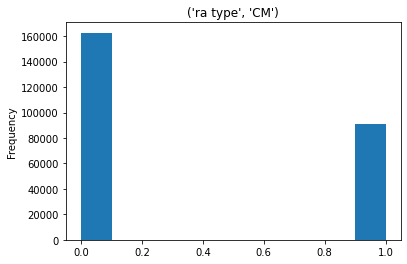

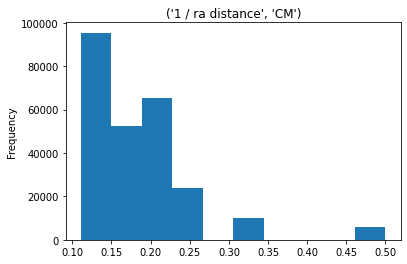

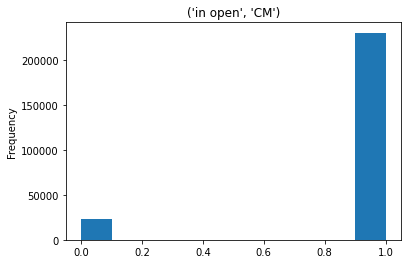

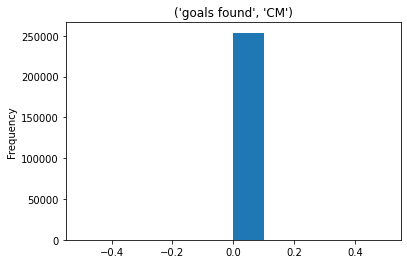

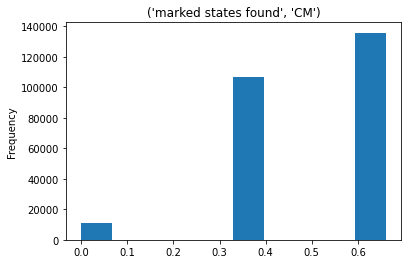

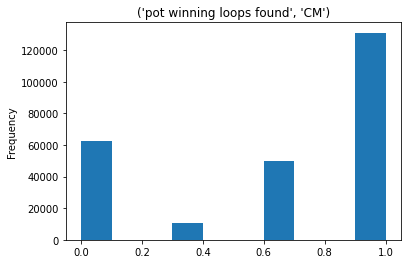

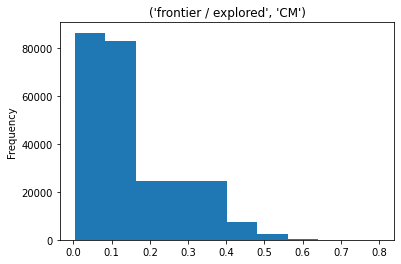

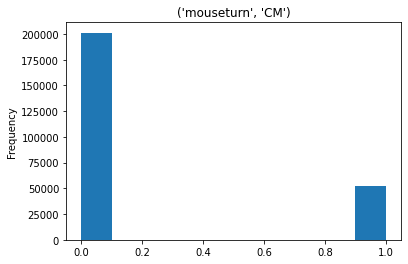

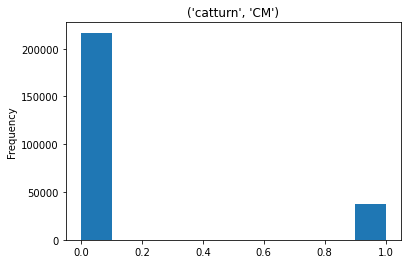

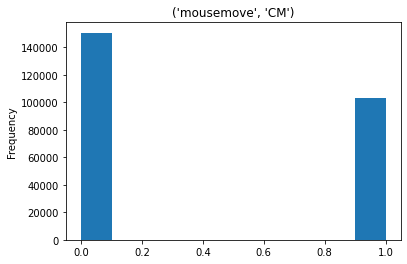

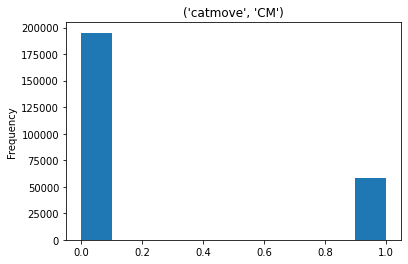

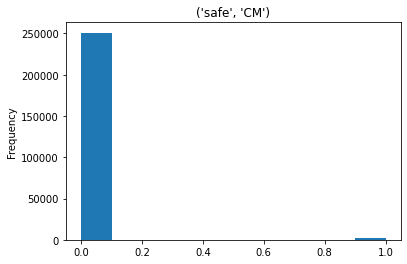

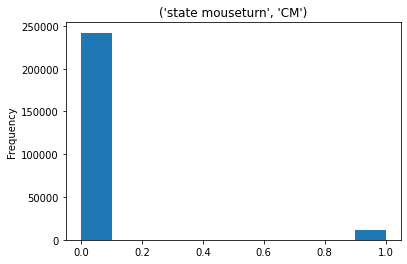

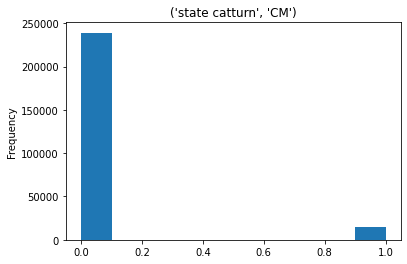

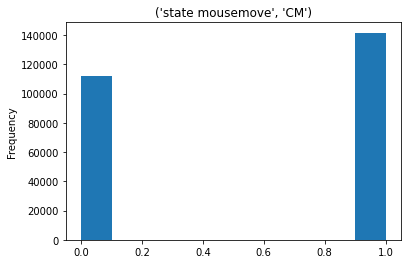

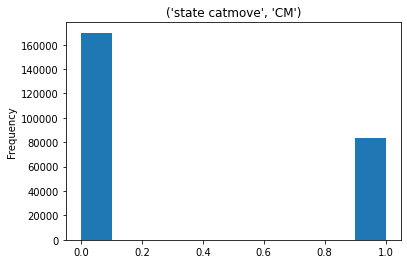

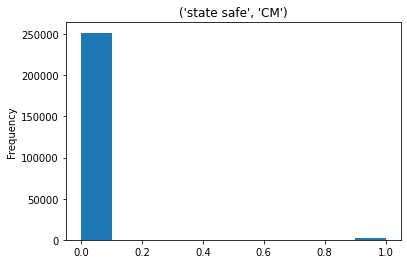

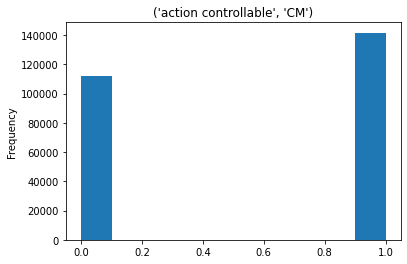

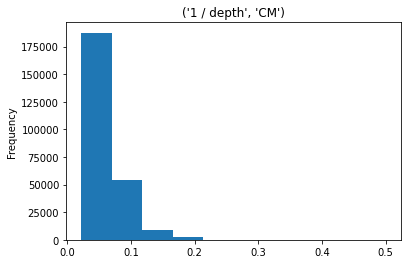

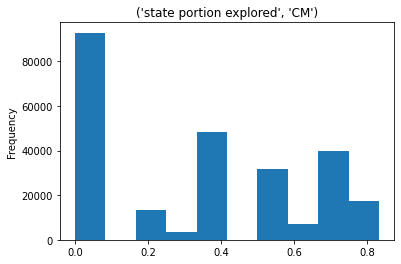

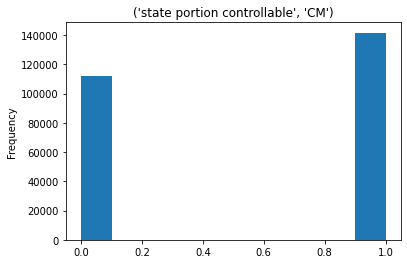

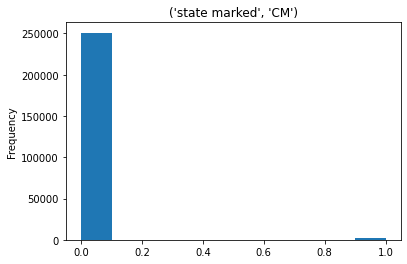

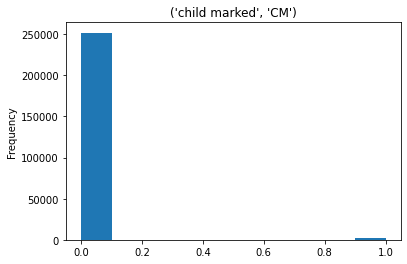

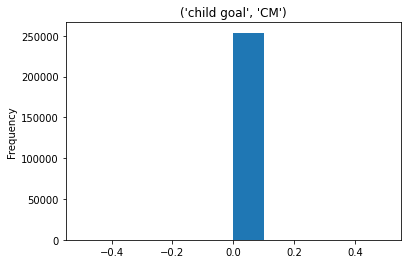

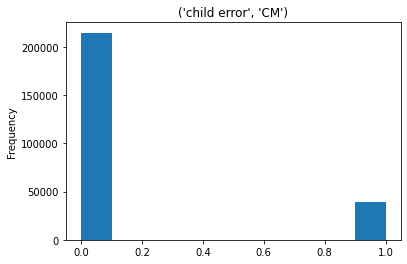

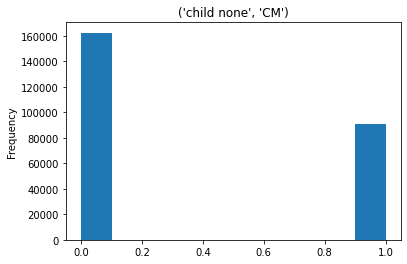

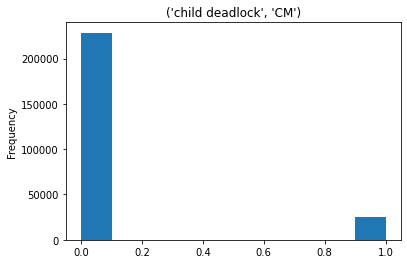

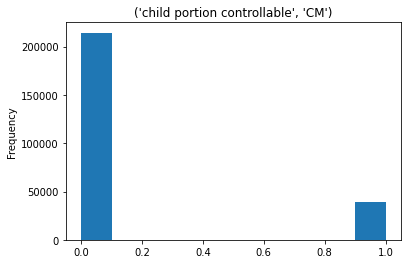

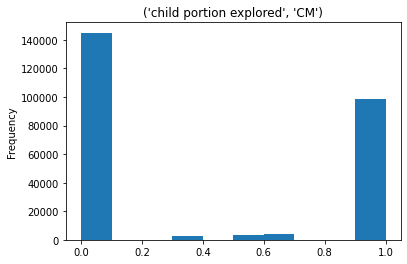

In [9]:
problem = "CM"
dfp = df.loc[df["problem"] == problem]
features = feature_names({"ra feature": True, "context features": True, "labels": True, "state labels": True}, problem)
for name in features:
    dfp[name].plot(kind='hist');
    plt.title((name, problem))
    plt.show()

In [ ]:
def plot_generalization(df, x="training time"):
    plot_ra_expanded_transitions(df["problem"].iloc[0], 2, 2, norm=True, color="r", label=None)
    plot_ra_expanded_transitions(df["problem"].iloc[0], 3, 3, norm=True, color="b", label=None)
    sns.lineplot(data=df, x=x, y="expanded transitions / total", hue="instance", palette=["r", "b"], ci=None)
    plt.xlabel(x, fontsize=14)
    plt.ylabel("expanded transitions / total", fontsize=14)
    plt.title(" ".join([problem, str(n), str(k)]))
    plt.ylim((0, 1))
    plt.tight_layout()

def plot_3_3(df):
    plot_ra_expanded_transitions(df["problem"].iloc[0], 3, 3, norm=True, color="b", label=None)
    sns.lineplot(data=df.loc[df["n"] == 3], x="rounded training time", y="expanded transitions / total", color="b", ci=None)
    plt.xlabel("training time", fontsize=14)
    plt.ylabel("expanded transitions / total", fontsize=14)
    #plt.title(" ".join([problem, str(n), str(k)]))
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.savefig("experiments/figures/trans_3_3/"+filename([problem, n, k, "trans_3_3"])+".png", dpi=200)
    plt.show()    

def plot_2_2(df):
    plot_ra_expanded_transitions(df["problem"].iloc[0], 2, 2, norm=True, color="r", label=None)
    sns.lineplot(data=df.loc[df["n"] == 2], x="rounded training time", y="expanded transitions / total", color="r", ci=None)
    plt.xlabel("training time", fontsize=14)
    plt.ylabel("expanded transitions / total", fontsize=14)
    #plt.title(" ".join([problem, str(n), str(k)]))
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.savefig("experiments/figures/trans_2_2/"+filename([problem, n, k, "trans_2_2"])+".png", dpi=200)
    plt.show()  
    
def plot_q(df):
    df2_2 = df.loc[df["n"] == 2]
    sns.lineplot(data=df2_2, x="rounded training time", y="expanded transitions", label="test")
    sns.lineplot(data=df2_2, x="rounded training time", y="avg q", label="avg q")
    plt.xlabel("training time")
    plt.title(" ".join([problem, str(n), str(k)]))
    plt.tight_layout()
    plt.savefig("experiments/figures/q/"+filename([problem, n, k, "q"])+".jpg", dpi=200)
    plt.show()
    
def plot_features(df, features, ra_feature, dir=None):
    df2_2 = df.loc[df["n"] == 2]
    fig = plt.figure(figsize=(10, 5), dpi=200)
    for feature in features:
        df2_2[feature] = -df2_2[feature]
        sns.lineplot(data=df2_2, x="rounded training time", y=feature, label=feature)
    
    plt.xlabel("training time")
    plt.title((problem, n, k, ra_feature))
    plt.tight_layout()
    if dir is not None:
        plt.savefig("experiments/figures/"+dir+"/features evolution/"+filename([problem, n, k, ra_feature])+".jpg", dpi=200)
    plt.show()
    
def plot_features_best(df, ra_feature, n, dir=None, last=False):
    names = feature_names(ra_feature)
    df = df.loc[df["n"] == n]
    if last:
        idx = df["idx"].max()
    else:
        idx = df.loc[df["expanded transitions"] == df["expanded transitions"].min()]["idx"].iloc[0]
    features = dict(-df.loc[df["idx"] == idx].iloc[0][names])
    
    fig = plt.figure(figsize=(10, 6), dpi=200)
    plt.bar(x=features.keys(), height=features.values(), width=0.3)
    plt.xticks(ha='right', rotation=55, fontsize=10)
    plt.title((problem, n, n, "idx = "+str(idx)))
    plt.tight_layout()
    if dir is not None:
        plt.savefig("experiments/figures/"+dir+"/best_features/"+filename([problem, n, n, ra_feature])+".jpg", dpi=200)
    plt.show()
    
def plot_comparison(df1, df2, n, x, y, dir=None):
    df = pd.concat([df1, df2], ignore_index=True)
    
    if y == "expanded transitions / total":
        plot_ra_expanded_transitions(df["problem"].iloc[0], n, n, norm=True, color="r", label=None)
    elif y == "expanded transitions":
        plot_ra_expanded_transitions(df["problem"].iloc[0], n, n, norm=False, color="r", label=None)
    
    sns.lineplot(data=df.loc[df["n"] == n], x=x, y=y, hue="features", color="r", ci=None)
    
    plt.xlabel("training time")
    plt.title(" ".join([problem, str(n), str(n)]))
    plt.tight_layout()
    if dir is not None:
        plt.savefig("experiments/figures/"+dir+"/"+filename([problem, n, n, "comp"])+".jpg", dpi=200)
    
    

In [ ]:
labels = {'descend.0.0', 'air.crash.1', 'land.0', 'requestLand.0', 'requestLand.1', 'air.crash.0', 'descend.1.0', 'control.all', 'approach.0', 'descend.0.1', 'extendFlight.1', 'land.1', 'descend.1.1', 'extendFlight.0', 'approach.1'}

def simplify(l):
    return "".join([c for c in l if c.isalpha()])

for label in labels:
    print(label, simplify(label))
    
print(labels)
print({simplify(l) for l in labels})

## Analyzing nn weights

In [ ]:
import onnx
from onnx import numpy_helper

weights = []
for idx in range(100):
    onnx_model = onnx.load("experiments/results/AT_3_3/5mill/" + str(idx)+".onnx")
    INTIALIZERS  = onnx_model.graph.initializer
    onnx_weights = {}
    for initializer in INTIALIZERS:
        W = numpy_helper.to_array(initializer)
        onnx_weights[initializer.name] = W
    w = onnx_weights["coefficient"]
    if True:
        for key, value in onnx_weights.items():
            if key == "coefficient1":
                print(key, value.min(), value.max())
    for feature in range(w.shape[0]):
        for node in range(w.shape[1]):
            weights.append({"t": idx, "val": w[feature, node], "feature": feature, "node": node})
    
weights = pd.DataFrame(weights)

In [ ]:
for feature in range(23):
    print(feature_names({"ra feature": True}, "AT")[feature])
    df = weights.loc[weights["feature"] == feature]
    sns.lineplot(data=df, x="t", y="val", hue="node")
    plt.show()